In [1]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yaojia\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [82]:
# author - Richard Liao
# Dec 26 2016
import numpy as np
import pandas as pd
import pickle
from collections import defaultdict
import matplotlib.pyplot as plt
import re

from nltk import tokenize
from bs4 import BeautifulSoup

import sys
import os
import seaborn as sns

import keras
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Merge, Embedding, Dropout, LSTM, GRU, Bidirectional, TimeDistributed
from keras.models import Model

from keras import backend as K
from keras.engine.topology import Layer, InputSpec
from keras import initializers

In [3]:
import tensorflow
tensorflow.__version__

'1.15.2'

In [4]:
keras.__version__

'2.0.8'

In [5]:
MAX_SENT_LENGTH = 100
MAX_SENTS = 15
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

## 1. Data Pre-Processing

In [6]:
def clean_str(string):
    """
    Tokenization/string cleaning for dataset
    Every dataset is lower cased except
    """
    string = re.sub(r"\\", "", string)
    string = re.sub(r"\'", "", string)
    string = re.sub(r"\"", "", string)
    return string.strip().lower()

In [25]:
# IMDB Data
data_train = pd.read_csv('labeledTrainData.tsv', sep='\t')
print(data_train.shape)

(25000, 3)


In [8]:
reviews = []
labels = []
texts = []

for idx in range(data_train.review.shape[0]):
    text = BeautifulSoup(data_train.review[idx])
    text = clean_str(text.get_text())
    texts.append(text)
    sentences = tokenize.sent_tokenize(text)
    reviews.append(sentences)

    labels.append(data_train.sentiment[idx])

tokenizer = Tokenizer(nb_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)

C:\Users\yaojia\AppData\Local\Programs\Python\Python36\lib\site-packages\keras\preprocessing\text.py:145: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


In [9]:
data = np.zeros((len(texts), MAX_SENTS, MAX_SENT_LENGTH), dtype='int32')

for i, sentences in enumerate(reviews):
    for j, sent in enumerate(sentences):
        if j < MAX_SENTS:
            wordTokens = text_to_word_sequence(sent)
            k = 0
            for _, word in enumerate(wordTokens):
                if k < MAX_SENT_LENGTH and tokenizer.word_index[word] < MAX_NB_WORDS:
                    data[i, j, k] = tokenizer.word_index[word]
                    k = k + 1

In [10]:
word_index = tokenizer.word_index
print('Total %s unique tokens.' % len(word_index))

labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

Total 81501 unique tokens.
Shape of data tensor: (25000, 15, 100)
Shape of label tensor: (25000, 2)


In [11]:
x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

print('Number of positive and negative reviews in traing and validation set')
print(y_train.sum(axis=0))
print(y_val.sum(axis=0))


Number of positive and negative reviews in traing and validation set
[10018.  9982.]
[2482. 2518.]


## 2. Embedding

In [12]:
GLOVE_DIR = "."
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'), encoding="utf8")
for line in f.readlines():
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [13]:
print('Total %s word vectors.' % len(embeddings_index))

Total 400000 word vectors.


In [14]:
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [15]:
# building Hierachical Attention network
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [16]:
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SENT_LENGTH,
                            trainable=True,
                            mask_zero=True)

## 3. Custom Attention Layer

In [17]:
class AttLayer(Layer):
    def __init__(self, attention_dim):
        self.init = initializers.get('normal')
        self.supports_masking = True
        self.attention_dim = attention_dim
        super(AttLayer, self).__init__()

    def build(self, input_shape):
        assert len(input_shape) == 3
        self.W = K.variable(self.init((input_shape[-1], self.attention_dim)), name='W')
        self.b = K.variable(self.init((self.attention_dim, )), name='b')
        self.u = K.variable(self.init((self.attention_dim, 1)), name='u')
        self.trainable_weights = [self.W, self.b, self.u]
        super(AttLayer, self).build(input_shape)

    def compute_mask(self, inputs, mask=None):
        return mask

    def call(self, x, mask=None):
        # size of x :[batch_size, sel_len, attention_dim]
        # size of u :[batch_size, attention_dim]
        # uit = tanh(xW+b)
        uit = K.tanh(K.bias_add(K.dot(x, self.W), self.b))
        ait = K.dot(uit, self.u)
        ait = K.squeeze(ait, -1)

        ait = K.exp(ait)

        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            ait *= K.cast(mask, K.floatx())
        ait /= K.cast(K.sum(ait, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        ait = K.expand_dims(ait)
        weighted_input = x * ait
        output = K.sum(weighted_input, axis=1)

        return output

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])



In [18]:
sentence_input = Input(shape=(MAX_SENT_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sentence_input)
l_lstm = Bidirectional(GRU(100, return_sequences=True))(embedded_sequences)
l_att = AttLayer(100)(l_lstm)
sentEncoder = Model(sentence_input, l_att)








Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



In [19]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6410814646651529830
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3188470579
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8753924562879030672
physical_device_desc: "device: 0, name: Quadro M1200, pci bus id: 0000:01:00.0, compute capability: 5.0"
]


## 4. Model Training

In [20]:
review_input = Input(shape=(MAX_SENTS, MAX_SENT_LENGTH), dtype='int32')
review_encoder = TimeDistributed(sentEncoder)(review_input)
l_lstm_sent = Bidirectional(GRU(100, return_sequences=True))(review_encoder)
l_att_sent = AttLayer(100)(l_lstm_sent)
preds = Dense(2, activation='softmax')(l_att_sent)
model = Model(review_input, preds)

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

print("model fitting - Hierachical attention network")
model.fit(x_train, y_train, validation_data=(x_val, y_val),
          epoch=5, batch_size=100)



model fitting - Hierachical attention network


C:\Users\yaojia\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Train on 20000 samples, validate on 5000 samples
Epoch 1/5
20000/20000 [==============================] - 214s - loss: 0.4507 - acc: 0.7828 - val_loss: 0.3216 - val_acc: 0.8668
Epoch 2/5
20000/20000 [==============================] - 211s - loss: 0.2853 - acc: 0.8818 - val_loss: 0.2848 - val_acc: 0.8812
Epoch 3/5
20000/20000 [==============================] - 206s - loss: 0.2278 - acc: 0.9085 - val_loss: 0.2757 - val_acc: 0.8892
Epoch 4/5
20000/20000 [==============================] - 212s - loss: 0.1789 - acc: 0.9291 - val_loss: 0.2905 - val_acc: 0.8870
Epoch 5/5
20000/20000 [==============================] - 206s - loss: 0.1362 - acc: 0.9493 - val_loss: 0.3037 - val_acc: 0.8900


In [21]:
model.save('./models/hatt_imdb.h5')

## 5. Visualize Attention

In [44]:
get_layer_output = K.function([model.layers[0].input, K.learning_phase()], [model.layers[2].output])
# test_seq = pad_sequences([sequences[index]], maxlen=MAX_SENT_LENGTH)
out = get_layer_output([data[[index], :, :], 0])[0]  # test mode
print(out[0].shape)

(15, 200)


In [60]:
att_w = K.get_value(model.layers[3].W)
att_w.shape

(200, 100)

In [63]:
eij = np.tanh(np.dot(out[0], att_w))
ai = np.exp(eij)
weights = ai/np.sum(ai)
weights.shape

(15, 100)

In [65]:
weights

array([[0.00049351, 0.0006318 , 0.00089227, ..., 0.0006286 , 0.00056188,
        0.00051069],
       [0.00104413, 0.00031536, 0.00060756, ..., 0.00050568, 0.00124608,
        0.00026897],
       [0.00111063, 0.00034225, 0.00042132, ..., 0.00056638, 0.00102431,
        0.00034483],
       ...,
       [0.0004641 , 0.00074793, 0.00096473, ..., 0.0005716 , 0.00053352,
        0.00067089],
       [0.00045655, 0.0007589 , 0.00100705, ..., 0.00056633, 0.00053957,
        0.00067049],
       [0.00045015, 0.00076557, 0.00104716, ..., 0.00056093, 0.00054751,
        0.00066679]], dtype=float32)

In [77]:
data[index, :, :]

array([[ 50,   9,  83, ...,   0,   0,   0],
       [  9, 127, 101, ...,   0,   0,   0],
       [ 17,  28,  62, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]])

In [96]:
reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))
reverse_word_map[0] = None

In [97]:
f = lambda x: reverse_word_map[x]
vf = np.vectorize(f)

In [98]:
vf(data[index, :, :])

array([['when', 'i', 'first', ..., 'None', 'None', 'None'],
       ['i', 'still', 'think', ..., 'None', 'None', 'None'],
       ['but', 'its', 'really', ..., 'None', 'None', 'None'],
       ...,
       ['None', 'None', 'None', ..., 'None', 'None', 'None'],
       ['None', 'None', 'None', ..., 'None', 'None', 'None'],
       ['None', 'None', 'None', ..., 'None', 'None', 'None']],
      dtype='<U14')

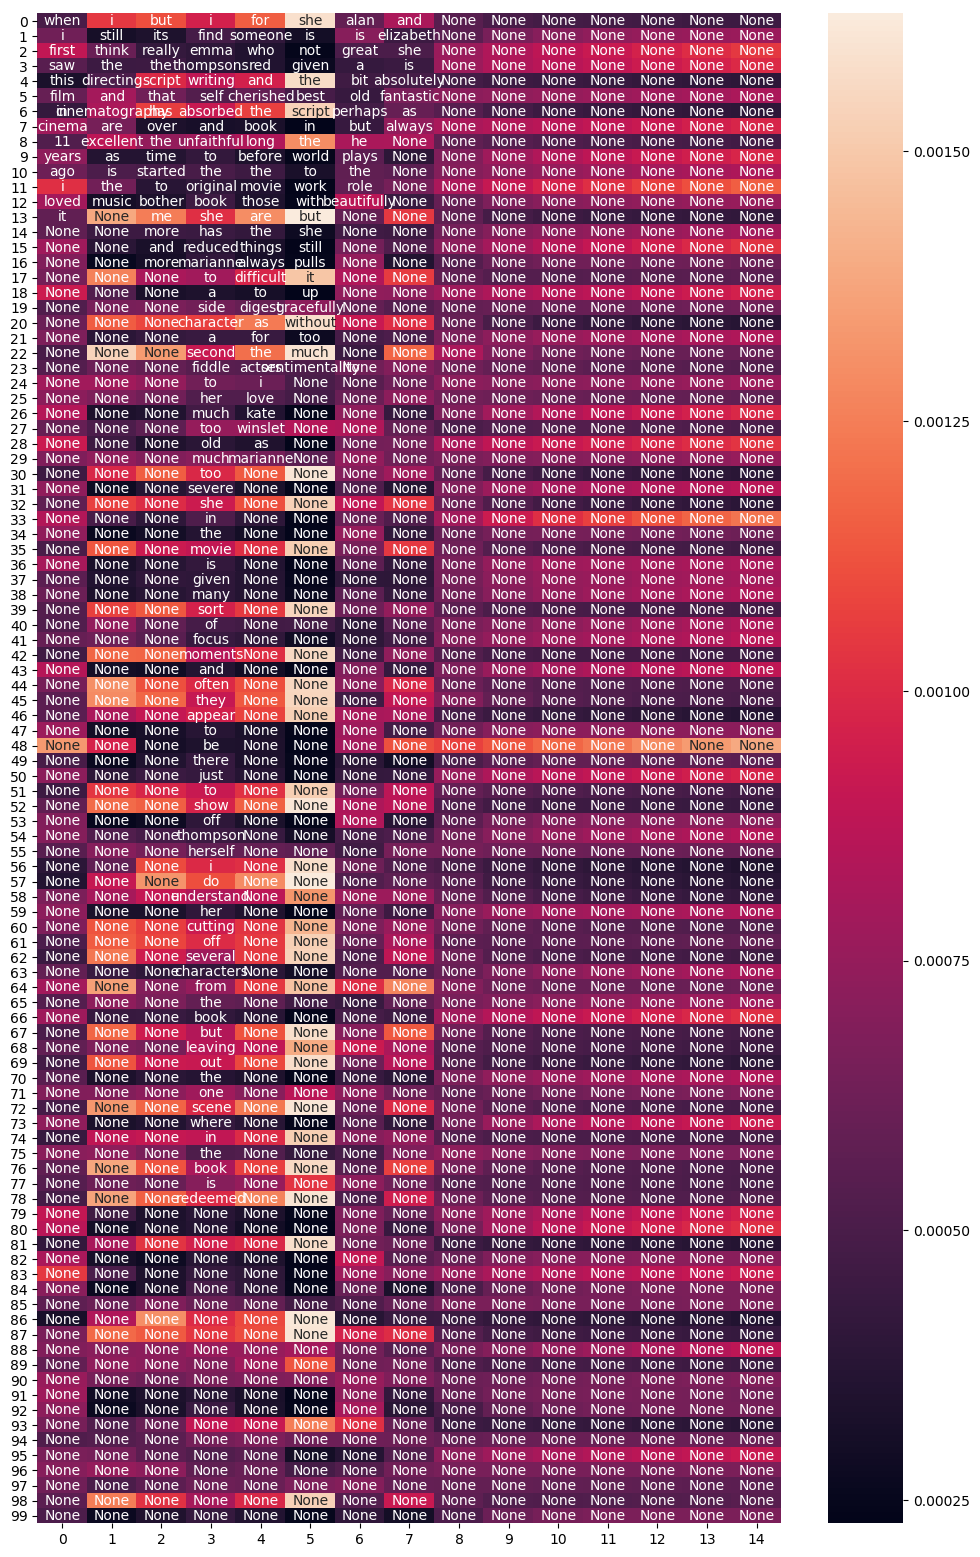

In [103]:
fig, ax = plt.subplots(figsize=(12,20), dpi=100)
sns.heatmap(weights.T, annot=vf(data[index, :, :]).T, fmt='s')

In [71]:
data_train.loc[0, 'review']

"With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.<br /><br />The actual feature film bit when it finally sta

In [64]:
top_k = 10
topKeys = np.argpartition(weights,-top_k)[-top_k:]
print(topKeys)
print(test_seq[0][topKeys])

[[31 99  2 92 91 84 83  7 82  9 80 11 12 79 73 15 16 70 18 66 59 53 50 48
  47 43 26 36 28 34 33 49 75 65 29 35 27 37 38 97 40 41 96 25 95 94 46 24
  23  1 93 51  3 21 54 55 90 89 58 88 60 61 85 63 64  5 19  8 68 10 17 71
  77 14 74 32 56 76 98 39 69 81 67  6 42 62 44 45 20  4  0 57 52 22 72 86
  30 13 78 87]
 [37 49 95 86 41 40 99 42  7  9 10 11 98 96 14  2  3 85 78 76 75 21 22 73
  24 70 66 65 63 62 59 31 57 55 54 50 36  6 38 45  5  4  0 74 43 39 97 13
  15  1 35 51 94 89 88 33 56 84 81 30 60 61 80 28 79 77 26 67 19 69 25 44
  72 23 71 34 48 47 18 92 29 58 91 83 90  8 16 46 52 53 27 17 12 32 82 20
  93 68 64 87]
 [49 99 31 50  4 92 91 86 84  9 80 73 12 70 14 66 16 59 53  3  1 47 43 41
  38 37 26 36 34  2 77 30 97 33 28 96 27 25 24 39 40 23 42 95 94 93  5 21
   6 90 19 89 88 18 54 55 56 57 58  7 60 61 85 63 29 65 15 83 68 82 81 71
  10 11 74 75 79  0 51 52 98 45 69 46  8 62 78 44 72 87 20 32 13 76 67 22
  35 48 17 64]
 [27 49 93 92  4 86 84 81 56 46 99 60  0 13 14 98 16 17 97 19 20 94